# Step 4. Models Training
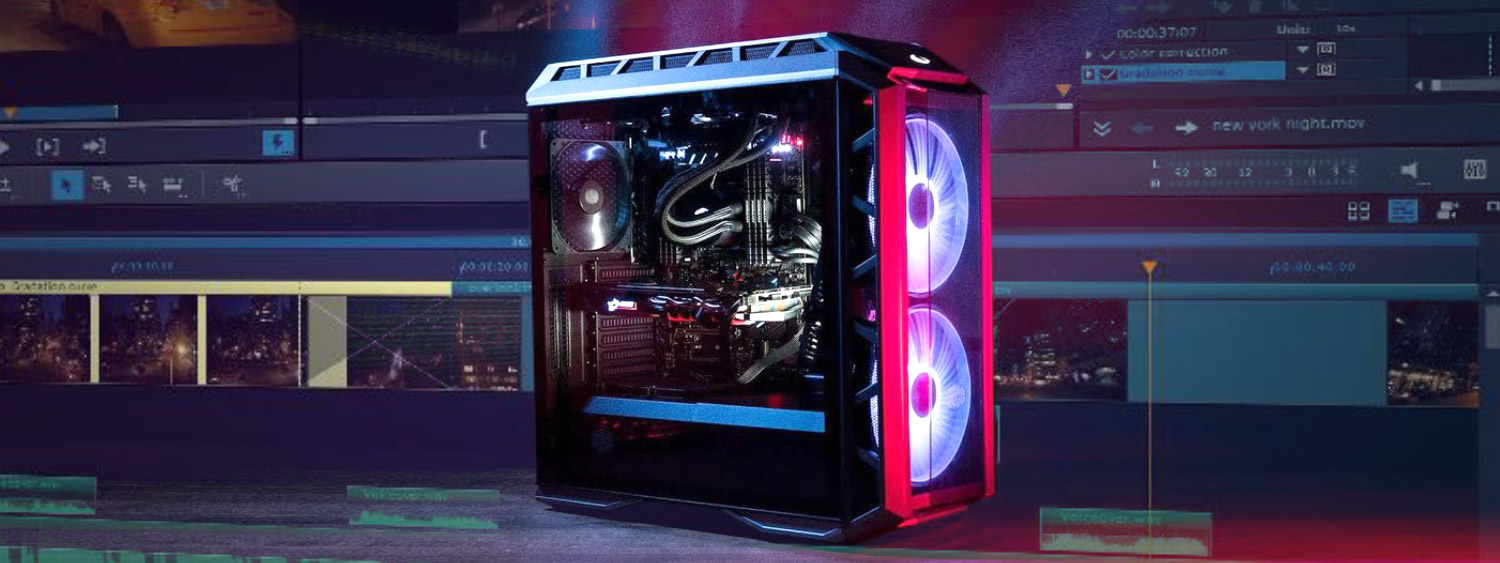

## TODO:
- without and with building_id
- **exclude bad rows from training**
- 0 site 4 - another pattern - separate model
- See forecasts for these rows:
    - 0 740
    - 2 1099 millions influence on accuracy - try to exclude from train
- Big differences in 2017-218 vs 2016:
    - 0 182 
    - 0 102
- Lack of observations:
    - 1 1018 1 observation only
    - 0 740 0 observations (400micro only)

## Import libraries

In [1]:
import sys
import warnings
import itertools

import pickle
from time import time
import datetime
import gc
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 150)
from colorama import Fore
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

from utility import plot_timeseries, convert_bytes_size

Load data from previous step:

In [5]:
datamart = pd.read_feather('./datasets/datamart_features.feather')
datamart.info(memory_usage='deep', null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61802460 entries, 0 to 61802459
Data columns (total 30 columns):
meter              61802460 non-null uint8
site_id            61802460 non-null uint8
building_id        61802460 non-null uint16
timestamp          61802460 non-null datetime64[ns]
row_id             41697600 non-null float64
primary_use        61802460 non-null uint8
square_feet        61802460 non-null float32
air_temperature    61802460 non-null float32
cloud_coverage     61802460 non-null uint8
hour               61802460 non-null uint8
day_of_week        61802460 non-null uint8
day_of_month       61802460 non-null uint8
day_of_year        61802460 non-null uint16
week_of_year       61802460 non-null uint8
month              61802460 non-null uint8
year               61802460 non-null uint16
s_mean             25567784 non-null float32
s_std              25567784 non-null float32
s_05               25567784 non-null float32
s_50               25567784 non-null float32

Filter datamart for fast testing:

In [17]:
sites_list = [2, 3]#[0, 1, 2, 4, 15]
index = (datamart['site_id'] == sites_list[0])
for site in sites_list[1:]:
    index = index | (datamart['site_id'] == site)
datamart = datamart[index]

Define functions for calculating forecasts accuracy:

In [8]:
def show_error(datamart, fact_col='target_log', fcst_col='fcst_log'):
    """Show forecast error metrics."""
    nonnan_index = (~datamart[fact_col].isna()) & (~datamart[fcst_col].isna())
    fact = datamart.loc[nonnan_index, fact_col]
    fcst = datamart.loc[nonnan_index, fcst_col]
    if not fact.empty:
        print(f'Sum {fact_col}: {fact.sum().astype(int):,}')
        print(f'Sum {fcst_col}: {fcst.sum().astype(int):,}')
        rmsle = mean_squared_error(fact, fcst)**0.5
        print('RMSLE: ' + Fore.RED + f'{rmsle:.3f}' + Fore.RESET)
    else:
        print(Fore.RED + 'Empty intersection of fact and fcst' + Fore.RESET)
    
def show_fcst_summary(datamart, model_sizes, fact_col='target_log', fcst_col='fcst_log', 
                      raw_leak_col = 'leak_log', group_col='model'):
    """Show forecast summary table by groups."""
    datamart = datamart.loc[:, [fact_col, raw_leak_col, fcst_col, group_col]]
    nonnan_index = (~datamart[fact_col].isna()) & (~datamart[fcst_col].isna())
    nonnan_index_raw = (~datamart[raw_leak_col].isna()) & (~datamart[fcst_col].isna())
    summary_table = pd.DataFrame()
    for group in list(datamart[group_col].unique()) + ['Total']:
        if group == 'Total':
            fact = datamart.loc[nonnan_index, fact_col]
            fcst = datamart.loc[nonnan_index, fcst_col]
            fact_raw = datamart.loc[nonnan_index_raw, raw_leak_col]
            fcst_raw = datamart.loc[nonnan_index_raw, fcst_col]
            model_size = sum(model_sizes.values())
        else:
            group_index = (datamart[group_col] == group)
            fact = datamart.loc[nonnan_index & group_index, fact_col]
            fcst = datamart.loc[nonnan_index & group_index, fcst_col]
            fact_raw = datamart.loc[nonnan_index_raw & group_index, raw_leak_col]
            fcst_raw = datamart.loc[nonnan_index_raw & group_index, fcst_col]
            if group in model_sizes.keys():
                model_size = model_sizes[group]
            else:
                model_size = 0
        if not fact.empty:
            summary_table = summary_table.append(pd.DataFrame({
                group_col: [group],
                f'sum {fact_col}': f'{fact.sum().astype(int):,}',
                f'sum {fcst_col}': f'{fcst.sum().astype(int):,}',
                'model size': convert_bytes_size(model_size),
                'RMSLE': f'{mean_squared_error(fact, fcst)**0.5: .3f}',
                'RMSLE raw': f'{mean_squared_error(fact_raw, fcst_raw)**0.5: .3f}',
            }, index=[group]))
        else:
            summary_table = summary_table.append(pd.DataFrame({
                group_col: [group],
                f'sum {fact_col}': f'{np.nan}',
                f'sum {fcst_col}': f'{np.nan}',
                'model size': '',
                'RMSLE': f'{np.nan}',
                'RMSLE raw': f'{np.nan}',
            }, index=[group]))
    display(summary_table.style.hide_index())

Define how to split data into separate models:

In [7]:
meter_names = {0: 'Electricity (0)', 1: 'Chilled water (1)',
               2: 'Steam (2)', 3: 'Hot water (3)'}
datamart['model'] = [meter_names[meter] for meter in datamart['meter']]
#datamart['model'] = 'all'

## Define machine learning algorithms

Random Forest from scikit-learn:

In [8]:
class RandomForestSklearn:
    """Random forest model from scikit-learn."""
    def __init__(self, numerical_features, categorical_features):
        self.model = RandomForestRegressor(
            n_estimators=30, max_features='sqrt',
            oob_score=False,
            # In order to reduce the size of the model, you can change these parameters:
            min_samples_split=2, max_leaf_nodes=None, max_depth=None, min_samples_leaf=1,
            random_state=0, n_jobs=-1,
        ) 
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
    def plot_feature_importances(self):
        features = numerical_features + categorical_features
        importances = self.model.feature_importances_
        indices = np.argsort(importances)
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [features[i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
        
    def get_size(self):
        p = pickle.dumps(self.model)
        size = sys.getsizeof(p)
        del p
        gc.collect()
        return size

**BOOSTING** from LightGBM:

In [9]:
class BoostingLightGBM:
    """Boosting model from LightGBM."""
    def __init__(self, numerical_features, categorical_features):
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
    
    def fit(self, X, y, X_val, y_val):
        X_val = X_val[~y_val.isna()]
        y_val = y_val[~y_val.isna()]
        self.model = lgb.LGBMRegressor(
            boosting='gbdt', metric='rmse', n_estimators=5000, num_leaves=40, 
            learning_rate=0.05, 
            min_sum_hessian_in_leaf=0.001, min_data_in_leaf=20, 
            subsample=0.8, subsample_freq=1, feature_fraction=0.4,
            reg_alpha=0, reg_lambda=2,
            silent=False, n_jobs=-1, random_state=0,
        )  
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            self.model.fit(
                X, y, 
                early_stopping_rounds=100, eval_set=(X_val, y_val), verbose=100,
                #feature_name=self.numerical_features+self.categorical_features,
                categorical_feature=self.categorical_features,
            )
        
    def fit_cv2(self, X, y, X_val, y_val):
        X_val = X_val[~y_val.isna()]
        y_val = y_val[~y_val.isna()]
        
        boosting_grid = ['gbdt']#, 'dart']
        num_leaves_grid = [40, 1200]#[40, 100, 140, 300, 800, 1200, 2000, 3000]
        learning_rate_grid = [0.05]
        reg_lambda_grid = [2]
        feature_fraction_grid = [0.4]
        
        param_grid = list(itertools.product(
            boosting_grid, num_leaves_grid, learning_rate_grid, reg_lambda_grid, feature_fraction_grid))
        results_table = pd.DataFrame()
        models = []
        for i, (boosting, num_leaves, learning_rate, reg_lambda, feature_fraction) in enumerate(param_grid):
            model = lgb.LGBMRegressor(
                boosting=boosting, metric='rmse', n_estimators=3000, 
                num_leaves=num_leaves, learning_rate=learning_rate, 
                min_sum_hessian_in_leaf=0.001, min_data_in_leaf=20, 
                subsample=0.8, subsample_freq=1, feature_fraction=feature_fraction,
                reg_alpha=0, reg_lambda=reg_lambda,
                silent=False, n_jobs=-1, random_state=0,
            )  
            st_time = time()
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(
                    X, y, 
                    early_stopping_rounds=100, eval_set=(X_val, y_val), verbose=False,
                    categorical_feature=self.categorical_features,
                )
            train_time = datetime.timedelta(seconds=int(time()-st_time))
            models.append(model)
            iter_results_table = pd.DataFrame({
                'boosting': boosting,
                'num_leaves': num_leaves,
                'learning_rate': learning_rate,
                'reg_lambda': reg_lambda,
                'feature_fraction': feature_fraction,
                'training time': train_time,
                'best iteration': model.best_iteration_,
                'best score': model.best_score_['valid_0']['rmse'],
            }, index=[i])
            display(iter_results_table)
            results_table = results_table.append(iter_results_table, ignore_index=True)
        display(results_table)
        best_model_index = results_table[['best score']].idxmin()[0] 
        print('Best model index is ' + Fore.YELLOW + f'{best_model_index}' + Fore.RESET)
        #print(f'Best model result is {results_table.loc[best_model_index, "best score"]:.3f}')
        self.model = models[best_model_index]
    
    def predict(self, X):
        return self.model.predict(X)
    
    def plot_feature_importances(self, importance_type='split'):
        lgb.plot_importance(
            self.model, ignore_zero=False, grid=False, importance_type=importance_type,  # 'split' or 'gain'
        )
        plt.show()
        
    def get_size(self):
        p = pickle.dumps(self.model)
        size = sys.getsizeof(p)
        del p
        gc.collect()
        return size

Build model for each segment:

Model for Electricity (0):
Size of train sample: 711.6 MB
Size of valid sample: 1.5 GB
Size of test sample: 1.5 GB


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
0,gbdt,40,0.05,2,0.4,00:07:52,804,0.46292


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
1,gbdt,1200,0.05,2,0.4,00:07:30,227,0.454373


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
0,gbdt,40,0.05,2,0.4,00:07:52,804,0.462920
1,gbdt,1200,0.05,2,0.4,00:07:30,227,0.454373


Best model index is 1
Model trained in 0:15:23
Size of model: 28.0 MB
Model predicted in 0:06:57
Sum target_log: 32,787,350
Sum fcst_log: 32,526,496
RMSLE: 0.454


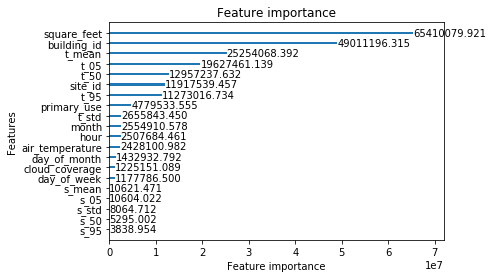

Model for Chilled water (1):
Size of train sample: 246.8 MB
Size of valid sample: 540.9 MB
Size of test sample: 540.9 MB


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
0,gbdt,40,0.05,2,0.4,00:01:07,178,1.497266


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
1,gbdt,1200,0.05,2,0.4,00:01:34,86,1.461256


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
0,gbdt,40,0.05,2,0.4,00:01:07,178,1.497266
1,gbdt,1200,0.05,2,0.4,00:01:34,86,1.461256


Best model index is 1
Model trained in 0:02:42
Size of model: 9.9 MB
Model predicted in 0:00:44
Sum target_log: 12,379,013
Sum fcst_log: 12,488,045
RMSLE: 1.461


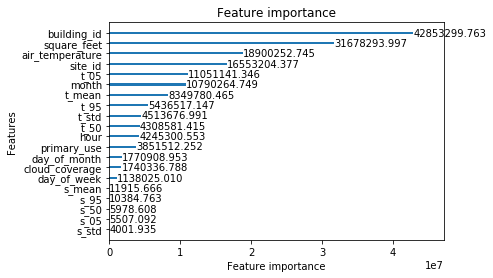

Model for Steam (2):
Size of train sample: 165.9 MB
Size of valid sample: 351.9 MB
Size of test sample: 351.9 MB


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
0,gbdt,40,0.05,2,0.4,00:01:00,394,0.986842


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
1,gbdt,1200,0.05,2,0.4,00:01:39,238,0.999535


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
0,gbdt,40,0.05,2,0.4,00:01:00,394,0.986842
1,gbdt,1200,0.05,2,0.4,00:01:39,238,0.999535


Best model index is 0
Model trained in 0:02:40
Size of model: 1.8 MB
Model predicted in 0:00:50
Sum target_log: 4,210,249
Sum fcst_log: 4,136,767
RMSLE: 0.987


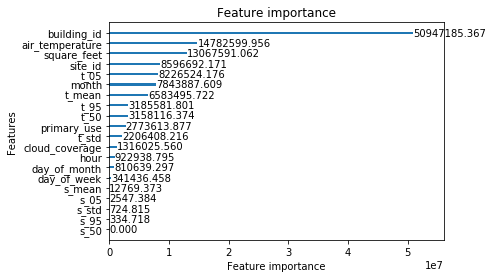

Model for Hot water (3):
Size of train sample: 77.7 MB
Size of valid sample: 157.5 MB
Size of test sample: 157.5 MB


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
0,gbdt,40,0.05,2,0.4,00:00:15,79,1.110869


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
1,gbdt,1200,0.05,2,0.4,00:00:38,86,1.109814


,boosting,num_leaves,learning_rate,reg_lambda,feature_fraction,training time,best iteration,best score
0,gbdt,40,0.05,2,0.4,00:00:15,79,1.110869
1,gbdt,1200,0.05,2,0.4,00:00:38,86,1.109814


Best model index is 1
Model trained in 0:00:54
Size of model: 9.2 MB
Model predicted in 0:00:12
Sum target_log: 2,125,307
Sum fcst_log: 2,044,676
RMSLE: 1.110


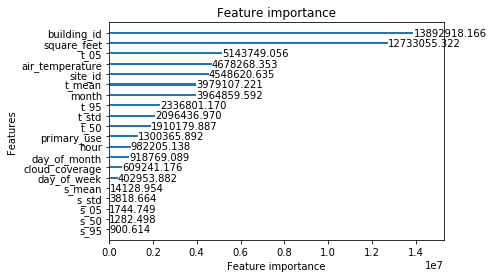

Total:
Sum target_log: 51,501,919
Sum fcst_log: 51,195,985
RMSLE: 0.892


In [10]:
numerical_features = [
    'day_of_week', 'day_of_month',
    #'day_of_year', 
    #'week_of_year', 
    'hour',
    'month',
    'air_temperature', 'cloud_coverage', 
    'square_feet',
    's_mean', 's_std', 's_05', 's_50', 's_95',
    't_mean', 't_std', 't_05', 't_50', 't_95',
]
categorical_features = [
    #'meter',
    'site_id', 
    'building_id',
    'primary_use',
]
compute_model_size = True
#model = RandomForestSklearn(numerical_features, categorical_features)
model = BoostingLightGBM(numerical_features, categorical_features)

datamart_compact = pd.DataFrame()
fact_with_fcst = pd.DataFrame()
model_sizes = {}

for model_group in datamart['model'].unique():
    print(Fore.BLUE + f'Model for {model_group}:' + Fore.RESET)
    X_test = pd.DataFrame()
    gc.collect()
    
    train_index = ((datamart['model'] == model_group)
        & (~datamart['target_log'].isna())
        & (datamart['timestamp'] >= '01/01/2016')  
        & (datamart['timestamp'] < '01/01/2017'))  
    val_index = ((datamart['model'] == model_group)
        & (datamart['timestamp'] >= '01/01/2017')
        & (datamart['timestamp'] < '01/01/2019'))
    test_index = ((datamart['model'] == model_group)
        & (datamart['timestamp'] >= '01/01/2017')
        & (datamart['timestamp'] < '01/01/2019'))
    
    X_train = datamart.loc[train_index, numerical_features + categorical_features] 
    y_train = datamart.loc[train_index, 'target_log']
    print(f'Size of train sample: {convert_bytes_size(X_train.memory_usage(deep=True).sum())}')
    X_val = datamart.loc[val_index, numerical_features + categorical_features] 
    y_val = datamart.loc[val_index, 'target_log']
    print(f'Size of valid sample: {convert_bytes_size(X_val.memory_usage(deep=True).sum())}')
    X_test = datamart.loc[test_index, numerical_features + categorical_features]
    y_test = datamart.loc[test_index, 'target_log']
    print(f'Size of test sample: {convert_bytes_size(X_test.memory_usage(deep=True).sum())}')
    start_time = time()
    model.fit_cv2(X_train, y_train, X_val, y_val)
    print('Model trained in ' + Fore.BLUE + 
          f'{datetime.timedelta(seconds=int(time()-start_time))}' + Fore.RESET)
    if compute_model_size:
        model_size = model.get_size()
    else:
        model_size = 0
    model_sizes[model_group] = model_size
    print(f'Size of model: {convert_bytes_size(model_size)}')

    start_time = time()
    y_fcst = model.predict(X_test)
    print('Model predicted in ' + Fore.BLUE + 
          f'{datetime.timedelta(seconds=int(time()-start_time))}' + Fore.RESET)
    fact_with_fcst_for_model = pd.DataFrame({'target_log': y_test, 'fcst_log': y_fcst}, index=X_test.index)
    show_error(fact_with_fcst_for_model)
    fact_with_fcst = fact_with_fcst.append(fact_with_fcst_for_model)
    model.plot_feature_importances(importance_type='gain')

fact_with_fcst['fcst'] = np.expm1(fact_with_fcst['fcst_log'])
datamart_compact = datamart[[
    'meter', 'site_id', 'building_id', 'timestamp', 'row_id', 'model', 
    'leak', 'leak_log', 'target', 'target_log',
]]
datamart_compact['fcst_log'] = fact_with_fcst['fcst_log']
datamart_compact['fcst'] = fact_with_fcst['fcst']
    
print(Fore.BLUE + 'Total:' + Fore.RESET)
show_error(datamart_compact)

Show summary table:

In [11]:
show_fcst_summary(datamart_compact, model_sizes)

model,sum target_log,sum fcst_log,model size,RMSLE,RMSLE raw
Electricity (0),"32,787,350","32,526,496",28.0 MB,0.454,0.657
Chilled water (1),"12,379,013","12,488,045",9.9 MB,1.461,1.461
Steam (2),"4,210,249","4,136,767",1.8 MB,0.987,0.987
Hot water (3),"2,125,307","2,044,676",9.2 MB,1.110,1.110
Total,"51,501,919","51,195,985",48.8 MB,0.892,0.965


Previous run:

In [24]:
show_fcst_summary(datamart_compact, model_sizes)

model,sum target_log,sum fcst_log,model size,RMSLE,RMSLE raw
all,"25,640,505","25,609,650",42.4 MB,0.890,1.012
Total,"25,640,505","25,609,650",42.4 MB,0.890,1.012


BEST TRY:

In [10]:
show_fcst_summary(datamart_compact, model_sizes)

model,sum target_log,sum fcst_log,model size,RMSLE,RMSLE raw
Electricity (0),"16,299,265","16,236,373",35.0 MB,0.406,0.735
Chilled water (1),"6,180,190","6,303,446",25.4 MB,1.436,1.436
Steam (2),"2,093,863","2,088,679",1.2 MB,0.952,0.952
Hot water (3),"1,067,187","993,143",726.7 KB,1.154,1.154
Total,"25,640,505","25,621,642",62.3 MB,0.871,0.993


**ALL DATA BENCHMARK 2018**

In [9]:
show_fcst_summary(datamart_compact, model_sizes)

model,sum target_log,sum fcst_log,model size,RMSLE,RMSLE raw
Electricity (0),"16,299,265","16,294,454",29.7 MB,0.416,0.746
Chilled water (1),"6,180,190","6,172,009",760.1 KB,1.367,1.368
Steam (2),"2,093,863","2,081,263",4.5 MB,0.885,0.885
Hot water (3),"1,067,187","1,079,086",249.9 KB,1.118,1.118
Total,"25,640,505","25,626,812",35.2 MB,0.839,0.968


Check for negative forecasts:

In [12]:
top_negatives = datamart_compact[datamart_compact['fcst'] < 0]\
    .groupby(['meter', 'site_id', 'building_id'])[['fcst']].count()\
    .rename(columns={'fcst': 'negatives_count'}).sort_values(by='negatives_count', ascending=False)
display(top_negatives.head(10))

negatives_count
meter site_id building_id                 
2     6       762                     8993
              772                     8222
              758                     7876
3     10      1003                    6416
2     15      1346                    6413
0     8       817                     5512
              845                     5457
2     14      1259                    4145
1     10      1022                    3888
              1013                    3771

In [13]:
plot_timeseries(datamart_compact, plot_fcst=True, rows_df=top_negatives)

interactive(children=(RadioButtons(description='meter', options=(('Electricity (0)', 0), ('Chilled water (1)',…

Clip negative forecasts:

In [14]:
datamart_compact['fcst'] = np.clip(datamart_compact['fcst'], 0, None)

Check for NaN forecasts:

In [23]:
#top_nan = datamart_compact[datamart_compact['fcst'].isna()]\
#    .groupby(['meter', 'site_id', 'building_id'])[['model']].count()\
#    .rename(columns={'model': 'nan_count'}).sort_values(by='nan_count', ascending=False)
#display(top_nan.head(10))

In [43]:
#plot_timeseries(datamart_compact, plot_fcst=True, rows_df=top_nan.head(10))

## Compute impact on results by row

In [24]:
def compute_se(datamart, fact_col='target_log', fcst_col='fcst_log'):
    nonnan_index = (~datamart[fact_col].isna()) & (~datamart[fcst_col].isna())
    fact = datamart.loc[nonnan_index, fact_col]
    fcst = datamart.loc[nonnan_index, fcst_col]
    if not fact.empty:
        return pd.Series([mean_squared_error(fact, fcst) * fact.shape[0], fact.shape[0]])
    else:
        return np.nan, np.nan

def compute_impact_by_row(datamart, fact_col='leak_log', fcst_col='fcst_log', 
                          group_cols=['meter', 'site_id', 'building_id']):
    """Compute impact on RMSE by row."""
    nonnan_index = (~datamart[fact_col].isna()) & (~datamart[fcst_col].isna())
    datamart = datamart.loc[nonnan_index, group_cols + [fact_col, fcst_col]]
    total_se, total_length = compute_se(datamart, fact_col=fact_col, fcst_col=fcst_col)
    impact = datamart.groupby(group_cols).apply(compute_se, fact_col=fact_col, fcst_col=fcst_col).reset_index()\
        .rename(columns={0: 'row_se', 1: 'row_length'})
    impact['row_rmse'] = (impact['row_se'] / impact['row_length']) ** 0.5
    impact['total_rmse'] = (total_se / total_length) ** 0.5
    impact['without_row_rmse'] = ((total_se - impact['row_se']) / (total_length - impact['row_length'])) ** 0.5
    impact['impact'] = impact['without_row_rmse'] - impact['total_rmse']
    return impact.sort_values(by='impact')

impact = compute_impact_by_row(datamart_compact[datamart_compact['building_id'] < 5000])
display(impact)

,meter,site_id,building_id,row_se,row_length,row_rmse,total_rmse,without_row_rmse,impact
438,1,0,30,392123.362390,17520.0,4.730906,0.965253,0.948950,-0.016302
439,1,0,31,250405.285026,17520.0,3.780547,0.965253,0.955131,-0.010122
431,1,0,7,228794.928897,17520.0,3.613734,0.965253,0.956070,-0.009183
451,1,0,96,220419.716513,17520.0,3.546975,0.965253,0.956433,-0.008819
535,1,2,260,216243.671808,17520.0,3.513214,0.965253,0.956615,-0.008638
...,...,...,...,...,...,...,...,...,...
312,0,4,592,153.781280,17518.0,0.093694,0.965253,0.965948,0.000695
168,0,2,169,153.460151,17520.0,0.093590,0.965253,0.965948,0.000695
345,0,4,627,148.902854,17518.0,0.092195,0.965253,0.965948,0.000695
115,0,1,115,128.582760,17520.0,0.085669,0.965253,0.965949,0.000696


Plot fact **vs** forecast:

In [22]:
plot_timeseries(datamart_compact, plot_fcst=True, use_log_values=False, rows_df=impact)

interactive(children=(RadioButtons(description='meter', options=(('Electricity (0)', 0), ('Chilled water (1)',…

In [3]:
plot_timeseries(datamart_compact, plot_fcst=True, use_log_values=False)

interactive(children=(RadioButtons(description='meter', options=(('Electricity (0)', 0), ('Chilled water (1)',…

## Blending with public


In [50]:
dtypes = {'row_id': np.float64, 'meter_reading': np.float64}
best_public_submission = pd.read_csv('./data/best_public_submission.csv', dtype=dtypes)
#best_public_submission = pd.read_csv('./submissions/submission 18.12.2019 22.14.csv', dtype=dtypes)
best_public_submission.rename(columns={'meter_reading': 'fcst_public'}, inplace=True)
best_public_submission['fcst_log_public'] = np.log1p(best_public_submission['fcst_public'])

In [51]:
datamart_compact.loc[~datamart_compact['leak'].isna(), 'fcst'] = datamart_compact['leak']

In [52]:
gc.collect()
datamart_compact_blended = datamart_compact.merge(best_public_submission, how='left', on='row_id')

In [47]:
datamart_public_plot = datamart_compact_blended
datamart_public_plot['fcst'] = datamart_public_plot['fcst_public']
plot_timeseries(datamart_public_plot, plot_fcst=True, use_log_values=False)

interactive(children=(RadioButtons(description='meter', options=(('Electricity (0)', 0), ('Chilled water (1)',…

In [53]:
datamart_compact_blended['fcst_blended'] = datamart_compact_blended['fcst_public']
datamart_compact_blended.loc[datamart_compact_blended['timestamp'] < '06.15.2017', 'fcst_blended'] = (
    1.0*datamart_compact_blended['fcst'] + 0.0*datamart_compact_blended['fcst_public'])
datamart_compact_blended['fcst'] = datamart_compact_blended['fcst_blended']

In [54]:
plot_timeseries(datamart_compact_blended, plot_fcst=True, use_log_values=False)

interactive(children=(RadioButtons(description='meter', options=(('Electricity (0)', 0), ('Chilled water (1)',…

In [55]:
datamart_compact = datamart_compact_blended

## Save results

Export submission file as csv:

In [56]:
use_leak_without_cleaning = True

submission_df = datamart_compact_blended.loc[~datamart_compact_blended['row_id'].isna(), ['row_id', 'leak', 'target', 'fcst']]
submission_df['row_id'] = submission_df['row_id'].astype(np.int32)
submission_df['meter_reading'] = submission_df['fcst']
if use_leak_without_cleaning:
    submission_df.loc[~submission_df['leak'].isna(), 'meter_reading'] = submission_df['leak']
else:
    submission_df.loc[~submission_df['target'].isna(), 'meter_reading'] = submission_df['target']
submission_df.drop(['leak', 'target', 'fcst'], axis=1, inplace=True)
submission_df = submission_df.sort_values(by='row_id').reset_index(drop=True)
display(submission_df)
if len(submission_df.index) != 41697600:
    raise ValueError('Submission is not full!')
if (submission_df['meter_reading'] < 0).any():
    raise ValueError('Negative meter readings in submission!')
if submission_df['meter_reading'].isna().any():
    raise ValueError('NaN meter readings in submission!')
now = datetime.datetime.now().strftime("%d.%m.%Y %H.%M")
submission_df.to_csv(f'./submissions/submission {now}.csv', index=False)

,row_id,meter_reading
0,0,173.370293
1,1,53.512720
2,2,6.143042
3,3,101.701470
4,4,1141.240666
...,...,...
41697595,41697595,6.409600
41697596,41697596,5.152900
41697597,41697597,2.789200
41697598,41697598,169.470400


In [58]:
submission_df['meter_reading'].isna().sum()

0

Export good forecast to feather:

In [32]:
now = datetime.datetime.now().strftime("%d.%m.%Y %H.%M")
datamart_compact.to_feather(f'./forecasts/forecast {now}.feather')

Load good forecast from feather:

In [2]:
datamart_compact = pd.read_feather('./forecasts/forecast 19.12.2019 21.45.feather')

## Notes

In [ ]:
def fit_cv(self, X, y, X_val, y_val):
        X_val = X_val[~y_val.isna()]
        y_val = y_val[~y_val.isna()]
        lgbm_boosting = lgb.LGBMRegressor(metric='rmse', silent=False, n_jobs=-1, random_state=0)
        param_grid = {
            'boosting': ['gbdt'],
            'n_estimators': [50, 100, 200, 500, 1000],
            'num_leaves': [40, 140, 300, 800, 1200],
            'learning_rate': [0.05],
            'min_data_in_leaf': [20],
            'min_sum_hessian_in_leaf': [0.001],
            'subsample': [0.4],
            'subsample_freq': [1],
            'feature_fraction': [0.4],
            'reg_alpha': [0],
            'reg_lambda': [2],#0
        }
        grid_search = GridSearchCV(
            lgbm_boosting, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', 
            verbose=1, refit=True, n_jobs=1,
        ) 
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            grid_search.fit(X, y, categorical_feature=self.categorical_features)
        #display(grid_search.cv_results_['mean_test_score'])
        print(f'Best score in cross-validation is {grid_search.best_score_:.3f}')
        best_params = grid_search.best_params_
        display(best_params)
        
        best_params['n_estimators'] = 9000
        self.model = lgb.LGBMRegressor(metric='rmse', silent=False, n_jobs=-1, random_state=0, **best_params)
        self.model.fit(
            X, y, 
            early_stopping_rounds=300, eval_set=(X_val, y_val), verbose=100,
            categorical_feature=self.categorical_features,
        )